In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from os.path import join

In [7]:
raw_dir = "raw/zhong_2020/"

In [5]:
adata = sc.read_mtx(join(raw_dir, "GSE119212_hippocampus_aggr_8_matrix.mtx.gz")).T
df_cell = pd.read_csv(join(raw_dir, "GSE119212_hippocampus_aggr_8_barcodes.tsv.gz"), sep='\t', header=None, index_col=0)
df_gene = pd.read_csv(join(raw_dir, "GSE119212_hippocampus_aggr_8_genes.tsv.gz"), sep='\t', header=None, index_col=1)
df_cell.index.name = "cell"
df_gene.index.name = "gene"
df_gene.columns = ["ensembl_id"]

adata.obs = df_cell
adata.var = df_gene

adata.write_h5ad("processed/zhong_2020.raw.h5ad")

In [6]:
df_hom = pd.read_csv(
    "/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/"
    "mouse_human_homologs.txt",
    sep="\t",
)
dict_hom = {row[1]: row[0] for _, row in df_hom.iterrows()}

In [9]:
adata = sc.read_h5ad("processed/zhong_2020.raw.h5ad")
adata.obs["batch"] = [str(x.split('-')[-1]) for x in adata.obs.index]
adata.obs["batch"] = adata.obs["batch"].astype("category")
df_cell_batch = pd.read_csv(join(raw_dir, "hippocampus-development-human-brain-10XV2.cell_id.csv.gz"), index_col=0)
dict_cell_batch = {i : row[0] for i, row in df_cell_batch.iterrows()}
adata.obs["batch_name"] = [dict_cell_batch[i[:-2]] for i in adata.obs.index]

sc.pp.filter_cells(adata, min_genes=800)
sc.pp.filter_cells(adata, max_genes=7000)
sc.pp.filter_genes(adata, min_cells=30)

adata.var['mt'] = adata.var_names.str.startswith('MT-')
haemoglobin_genes = ["HBM", "HBA1", "HBA2", "HBB", "HBD", "HBE1", "HBG1", "HBG2", "HBQ1", "HBZ"]
adata.var['haemoglobin'] = adata.var_names.isin(haemoglobin_genes)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', "haemoglobin"], percent_top=None, log1p=False, inplace=True)
adata = adata[(adata.obs.pct_counts_mt < 15) & (adata.obs.pct_counts_haemoglobin < 5), :]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: Future

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


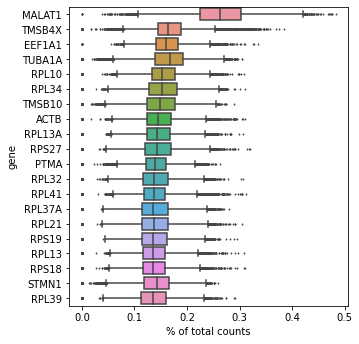

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highest_expr_genes(adata, n_top=20, )

adata = adata[:, adata.var.highly_variable]

In [11]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.set_figure_params(dpi=150)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
raw_adata = adata.raw.to_adata()
raw_adata.var_names_make_unique()
raw_adata.write_h5ad("processed/zhong_2020.processed.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
df_cov = raw_adata.obs[["batch_name", "n_genes"]]
df_cov["const"] = 1.
pd.get_dummies(df_cov, drop_first=True).to_csv("processed/zhong_2020.cov.tsv", sep='\t')

<ipython-input-15-b1f5838a5dfc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cov["const"] = 1.
